<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 14 - Submission 2 with Generators!
### Applied Machine Learning


I have included many link for resources in this notebook.  Please note that technically when you read the validation and tests set in as image generators you would not shuffle them.  Only the training needs to be shuffled.  I however imorted a shuffled test generator to run a prediction and then recreated the generated with the same random seed to obtain the true values.  You will see where I indicate this halfway through.

The point of this notebook is that it only reads 32 3-D arrays into memory at one time instead of over 14000 3-D arrays.

In [1]:
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

See the directory folder structure required under `The dataset has the following directory structure:` at the following site:
https://www.tensorflow.org/tutorials/images/classification

In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

_labels = np.array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
_path = 'intel-image-classification'

## set generator scale, from https://www.tensorflow.org/tutorials/images/classification
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_path = _path + '/seg_train/seg_train/'
## read in already shuffled
train_data_gen = image_generator.flow_from_directory(directory=train_path,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=42,
                                                     color_mode='rgb',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(_labels))

Found 14034 images belonging to 6 classes.


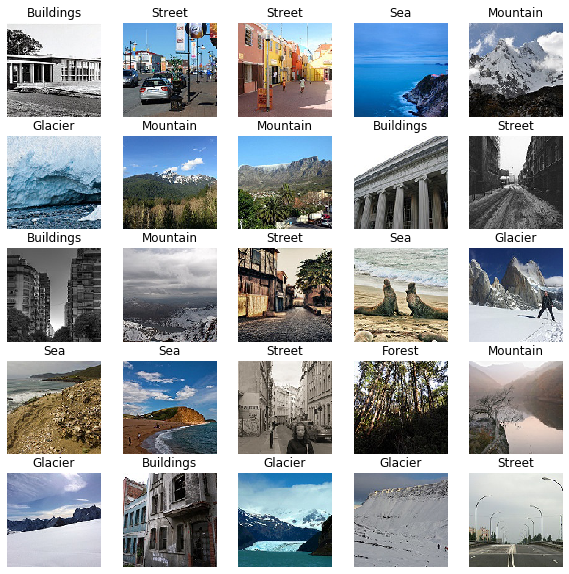

In [3]:
## batch size is 32, so we print 25 of them from the training for sanity
## from https://www.tensorflow.org/tutorials/load_data/images
from PIL import Image

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(_labels[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [4]:
## setup CNN
from tensorflow.keras import layers
tf.keras.backend.clear_session()

#input_shape = (None, 28, 28, 3)
singe_input_shape = image_batch[0].shape

## run faster with filters=4, filters=8 and units=16
nn2 = tf.keras.Sequential([
    layers.Conv2D(filters=4, kernel_size=(5,5), data_format='channels_last',
                  input_shape=singe_input_shape, name='conv1', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'),
    layers.Conv2D(filters=8, kernel_size=(5,5),
                  name='conv2', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'),
    layers.Flatten(),
    layers.Dense(units=16, name='fc_1', activation='relu'),
    layers.Dense(units=6, name='fc_2', activation='softmax')
])

## you need to use BinaryCrossentropy
## see Compile the model @https://www.tensorflow.org/tutorials/images/classification
nn2.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

## don't need to build to see summary if you include input_shape in first layer Sequential
nn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 124, 124, 4)       304       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 62, 62, 4)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 58, 58, 8)         808       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 29, 29, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6728)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 16)                107664    
_________________________________________________________________
fc_2 (Dense)                 (None, 6)                 1

In [5]:
## train

## steps in entire training set
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size  ## 14034 / 32 = 438
NUM_EPOCHS = 10

## in Keras 2.1 fit_generators is deprecated, use fit
## https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit_generator
history2 = nn2.fit(train_data_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   epochs=NUM_EPOCHS,
                   verbose=1)            

  ...
    to  
  ['...']
Train for 438 steps
Epoch 1/10
438/438 [==============================] - 91s 207ms/step - loss: 0.7157 - accuracy: 0.8392
Epoch 2/10
438/438 [==============================] - 85s 194ms/step - loss: 0.7010 - accuracy: 0.8579
Epoch 3/10
438/438 [==============================] - 89s 204ms/step - loss: 0.6975 - accuracy: 0.8654
Epoch 4/10
438/438 [==============================] - 86s 197ms/step - loss: 0.6958 - accuracy: 0.8677
Epoch 5/10
438/438 [==============================] - 87s 199ms/step - loss: 0.6938 - accuracy: 0.8724
Epoch 6/10
438/438 [==============================] - 87s 198ms/step - loss: 0.6920 - accuracy: 0.8755
Epoch 7/10
438/438 [==============================] - 86s 196ms/step - loss: 0.6913 - accuracy: 0.8773
Epoch 8/10
438/438 [==============================] - 87s 198ms/step - loss: 0.6901 - accuracy: 0.8796
Epoch 9/10
438/438 [==============================] - 97s 220ms/step - loss: 0.6871 - accuracy: 0.8857
Epoch 10/10
438/438 [=======

Read in test data.  We can shuffle this but then we need to reinstantiate the iterator with same seed to get the labels after we run predict.

In [6]:
## get test

test_path = _path + '/seg_test/seg_test/'
## read in already shuffled for testing
test_data_gen = image_generator.flow_from_directory(directory=test_path,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(_labels))

Found 3000 images belonging to 6 classes.


In [7]:
## predict

## get prediction probabilities from softmax
y_pred_probs = nn2.predict(test_data_gen, verbose=1)

94/94 [==============================] - 8s 86ms/step


In [8]:
## get predictions from probabilities
y_pred = np.argmax(y_pred_probs, axis=-1)
print(len(y_pred))
y_pred

## make sure all classes have predictions
## ironically I tested a few times and it skipped predicting buildings
np.unique(y_pred)

3000


array([0, 1, 2, 3, 4, 5])

#### So this is tricky.  We have to get the test labels in the order we shuffled in the `ImageDataGenerator`.  Have no fear we can get that by resetting the generator with the same random seed we read in the test set and abstract the true labels in a loop.

Found 3000 images belonging to 6 classes.
3000


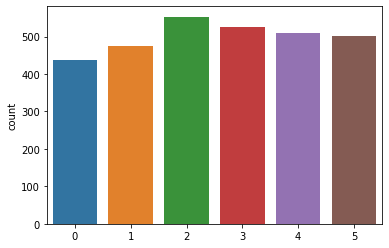

In [9]:
## make sure we reset the generator with same seed
test_path = _path + '/seg_test/seg_test/'
test_data_gen = image_generator.flow_from_directory(directory=test_path,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(_labels))

## steps in entire test set
STEP_SIZE_TEST=test_data_gen.n//test_data_gen.batch_size  ## 3000 / 32 = 93

## get test labels from generator for confusion matrix
## only need to do this once
## when we create the test generator for dropout test it will be same seed
y_test_labels = []
for _ in range(STEP_SIZE_TEST + 1):
    image_batch, label_batch = next(test_data_gen)
    y_test_labels.append(np.where(label_batch==1)[1])

y_test = [item for sublist in y_test_labels for item in sublist]
print(len(y_test)) # sanity
sns.countplot(y_test)

In [10]:
from sklearn.metrics import confusion_matrix
import pandas as pd

## ALWAYS add y_true first for confusion matrices because they make the truth the y-axis i.e. the rows
## see https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=_labels, columns=_labels)
cm_df_perc = round(cm_df.div(cm_df.sum(axis=1), axis=0), 3)
cm_df_perc

,buildings,forest,glacier,mountain,sea,street
buildings,0.625,0.050,0.021,0.050,0.066,0.188
forest,0.038,0.863,0.002,0.004,0.004,0.089
glacier,0.031,0.004,0.575,0.121,0.219,0.051
mountain,0.050,0.002,0.095,0.699,0.139,0.015
sea,0.080,0.016,0.271,0.224,0.386,0.024
street,0.122,0.072,0.042,0.010,0.018,0.737


In [11]:
class_accs = dict()
for i in range(6):
    class_accs[cm_df_perc.index[i]] = cm_df_perc.iloc[i, i]
sorted_accuracies = sorted(class_accs.items(), key=lambda x: x[1], reverse=True)

print("Sorted class accuracies:\n", sorted_accuracies)
print()
print("Total test accuracy =", f'{sum(np.equal(y_test, y_pred))/3000:.3f}')

Sorted class accuracies:
 [('forest', 0.863), ('street', 0.737), ('mountain', 0.699), ('buildings', 0.625), ('glacier', 0.575), ('sea', 0.386)]

Total test accuracy = 0.644


Highest accuracy is `forest` and lowest is `seas`.  It goes back and forth between buildings and seas for the lowest.  Since neural networks use randomness it all depends on the random initialization which categories have the lowest in this model.  Typically you can get repeat results by setting numpy random seed as in below at top of script:

`from numpy.random import seed
seed(1)`

### Now try with dropout and regularization.

In [12]:
from tensorflow.keras import regularizers

## run faster with filters=4, filters=8 and units=16
nn3 = tf.keras.Sequential([
    layers.Conv2D(filters=4, kernel_size=(5,5), data_format='channels_last',
                  input_shape=singe_input_shape, name='conv1', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'),
    layers.Dropout(rate=0.3),
    layers.Conv2D(filters=8, kernel_size=(5,5),
                  name='conv2', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'),
    layers.Dropout(rate=0.3),
    layers.Flatten(),
    layers.Dense(units=16, name='fc_1', activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    layers.Dense(units=6, name='fc_2', activation='softmax', activity_regularizer=regularizers.l2(1e-5))
])

## you need to use BinaryCrossentropy
## see Compile the model @https://www.tensorflow.org/tutorials/images/classification
nn3.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

## don't need to build to see summary if you include input_shape in first layer Sequential
nn3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 124, 124, 4)       304       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 62, 62, 4)         0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 4)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 58, 58, 8)         808       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 29, 29, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6728)             

In [13]:
## you'd probably want to create train and test generator functions during testing cause you will call with
## same seed a few times trying different things with the same train and test data shuffles
train_data_gen = image_generator.flow_from_directory(directory=train_path,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=42,
                                                     color_mode='rgb',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(_labels))

history3 = nn3.fit(train_data_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   epochs=NUM_EPOCHS,
                   verbose=1)   

Found 14034 images belonging to 6 classes.
  ...
    to  
  ['...']
Train for 438 steps
Epoch 1/10
438/438 [==============================] - 114s 260ms/step - loss: 0.7150 - accuracy: 0.8470
Epoch 2/10
438/438 [==============================] - 105s 240ms/step - loss: 0.7017 - accuracy: 0.8643
Epoch 3/10
438/438 [==============================] - 104s 236ms/step - loss: 0.6969 - accuracy: 0.8738
Epoch 4/10
438/438 [==============================] - 110s 252ms/step - loss: 0.6896 - accuracy: 0.8879
Epoch 5/10
438/438 [==============================] - 106s 242ms/step - loss: 0.6828 - accuracy: 0.9023
Epoch 6/10
438/438 [==============================] - 101s 230ms/step - loss: 0.6779 - accuracy: 0.9115
Epoch 7/10
438/438 [==============================] - 100s 228ms/step - loss: 0.6750 - accuracy: 0.9164
Epoch 8/10
438/438 [==============================] - 105s 241ms/step - loss: 0.6726 - accuracy: 0.9216
Epoch 9/10
438/438 [==============================] - 110s 250ms/step - loss: 0.

In [14]:
## get test and predict 

test_data_gen = image_generator.flow_from_directory(directory=test_path,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(_labels))

y_pred_probs2 = nn3.predict(test_data_gen, verbose=1)
y_pred2 = np.argmax(y_pred_probs2, axis=-1)

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 9s 93ms/step


In [15]:
cm2 = confusion_matrix(y_test, y_pred2)
cm_df2 = pd.DataFrame(cm2, index=_labels, columns=_labels)
cm_df_perc2 = round(cm_df2.div(cm_df2.sum(axis=1), axis=0), 3)

class_accs2 = dict()
for i in range(6):
    class_accs2[cm_df_perc2.index[i]] = cm_df_perc2.iloc[i, i]
sorted_accuracies2 = sorted(class_accs2.items(), key=lambda x: x[1], reverse=True)

print("Sorted class accuracies with dropout:\n", sorted_accuracies2)
print()
print("Total test accuracy with dropout =", f'{sum(np.equal(y_test, y_pred2))/3000:.3f}')

Sorted class accuracies with dropout:
 [('forest', 0.947), ('street', 0.78), ('mountain', 0.72), ('glacier', 0.712), ('sea', 0.657), ('buildings', 0.595)]

Total test accuracy with dropout = 0.736


#### Interesting this time dropout did better with just 10 epochs.  Every other time I tested with just 10 epochs for training, dropout did slightly worse.  We can try a training more epochs but less training data; same size as test data so see if training without dropout overfits the data.

In [16]:
from tensorflow.keras import layers

def get_train_gen(seed=42, directory=None):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      validation_split=.786)
    train_data_gen = image_generator.flow_from_directory(directory=directory,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=seed,
                                                         color_mode='rgb',
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes = list(_labels),
                                                         subset='training')
    return train_data_gen


def get_test_gen(seed=42, directory=None):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_data_gen = image_generator.flow_from_directory(directory=directory,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=True,
                                                        seed=seed,
                                                        color_mode='rgb',
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        classes = list(_labels))
    return test_data_gen


def run_CNN(num_epochs=25, train_gen=None, test_gen=None, dropout_reg=False):
    tf.keras.backend.clear_session()
    singe_input_shape = (128, 128, 3)
    NUM_EPOCHS = num_epochs
    
    if dropout_reg:
        from tensorflow.keras import regularizers
        nn = tf.keras.Sequential([
            layers.Conv2D(filters=4, kernel_size=(5,5), data_format='channels_last',
                          input_shape=singe_input_shape, name='conv1', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'),
            layers.Dropout(rate=0.3),
            layers.Conv2D(filters=8, kernel_size=(5,5),
                          name='conv2', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'),
            layers.Dropout(rate=0.3),
            layers.Flatten(),
            layers.Dense(units=16, name='fc_1', activation='relu', activity_regularizer=regularizers.l2(1e-4)),
            layers.Dense(units=6, name='fc_2', activation='softmax', activity_regularizer=regularizers.l2(1e-4))
        ])
    
    else: 
        nn = tf.keras.Sequential([
            layers.Conv2D(filters=4, kernel_size=(5,5), data_format='channels_last',
                          input_shape=singe_input_shape, name='conv1', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'),
            layers.Conv2D(filters=8, kernel_size=(5,5),
                          name='conv2', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'),
            layers.Flatten(),
            layers.Dense(units=16, name='fc_1', activation='relu'),
            layers.Dense(units=6, name='fc_2', activation='softmax')
        ])

    ## you need to use BinaryCrossentropy
    ## see Compile the model @https://www.tensorflow.org/tutorials/images/classification
    nn.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])
    
    STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size  ## 3005 / 32 = 93

    history = nn.fit(train_gen,
                     steps_per_epoch=STEP_SIZE_TRAIN,
                     epochs=NUM_EPOCHS,
                     verbose=1)  
    
    y_pred_probs = nn.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=-1)
    
    return y_pred

In [20]:
train_data_gen = get_train_gen(42, train_path)
test_data_gen = get_test_gen(42, test_path)


from numpy.random import seed
seed(1)
y_pred_no_dropout = run_CNN(num_epochs=40, 
                            train_gen=train_data_gen, 
                            test_gen=test_data_gen, 
                            dropout_reg=False)

Found 3005 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
  ...
    to  
  ['...']
Train for 93 steps
Epoch 1/40
93/93 [==============================] - 23s 247ms/step - loss: 0.7300 - accuracy: 0.8195
Epoch 2/40
93/93 [==============================] - 21s 227ms/step - loss: 0.7184 - accuracy: 0.8238
Epoch 3/40
93/93 [==============================] - 24s 254ms/step - loss: 0.7134 - accuracy: 0.8336
Epoch 4/40
93/93 [==============================] - 20s 210ms/step - loss: 0.7126 - accuracy: 0.8334
Epoch 5/40
93/93 [==============================] - 21s 223ms/step - loss: 0.7131 - accuracy: 0.8325
Epoch 6/40
93/93 [==============================] - 19s 209ms/step - loss: 0.7101 - accuracy: 0.8400
Epoch 7/40
93/93 [==============================] - 21s 229ms/step - loss: 0.7093 - accuracy: 0.8422
Epoch 8/40
93/93 [==============================] - 24s 256ms/step - loss: 0.7097 - accuracy: 0.8403
Epoch 9/40
93/93 [==============================] - 20s 212ms/st

In [21]:
train_data_gen = get_train_gen(42, train_path)
test_data_gen = get_test_gen(42, test_path)

seed(1)
y_pred_with_dropout = run_CNN(num_epochs=40, 
                              train_gen=train_data_gen, 
                              test_gen=test_data_gen, 
                              dropout_reg=True)

Found 3005 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
  ...
    to  
  ['...']
Train for 93 steps
Epoch 1/40
93/93 [==============================] - 26s 285ms/step - loss: 0.7428 - accuracy: 0.8334
Epoch 2/40
93/93 [==============================] - 28s 298ms/step - loss: 0.7357 - accuracy: 0.8366
Epoch 3/40
93/93 [==============================] - 26s 277ms/step - loss: 0.7315 - accuracy: 0.8395
Epoch 4/40
93/93 [==============================] - 24s 254ms/step - loss: 0.7248 - accuracy: 0.8478
Epoch 5/40
93/93 [==============================] - 25s 264ms/step - loss: 0.7188 - accuracy: 0.8561
Epoch 6/40
93/93 [==============================] - 23s 243ms/step - loss: 0.7149 - accuracy: 0.8619
Epoch 7/40
93/93 [==============================] - 23s 244ms/step - loss: 0.7097 - accuracy: 0.8665
Epoch 8/40
93/93 [==============================] - 23s 249ms/step - loss: 0.7076 - accuracy: 0.8735
Epoch 9/40
93/93 [==============================] - 23s 244ms/st

In [22]:
print("Total test accuracy without dropout =", f'{sum(np.equal(y_test, y_pred_no_dropout))/3000:.3f}')
print()
print("Total test accuracy with dropout =", f'{sum(np.equal(y_test, y_pred_with_dropout))/3000:.3f}')

Total test accuracy without dropout = 0.506

Total test accuracy with dropout = 0.664


So here obviously 3005 images is not enough to train the data.  But without dropout we overfit the training data as we can see by the increase in accuracy using dropout with 40 epochs each.